# Libraries used 
__Numpy__ : Fundamental package for scientific computing in Python3 <br>
__Matplotlib__ : A Python3 plotting library used for data visualization <br>
__SkImage__ : Is an open source Python3 package designed for image processing <br>
__Tensorflow__ : Is an open source deep learning framework for dataflow and differentiable programming <br>
__Tqdm__ : Is a progress bar library with good support for nested loops and Jupyter notebooks  <br>
__OpenCV__ :is a great tool for image processing and performing computer vision tasks.<br>
__Pandas__ : is a fast, powerful, flexible and easy to use open source data analysis and manipulation tool, built on top of the Python programming language

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline
import cv2
import skimage.color as sk
from tqdm import tqdm_notebook as tqdm

# Dataset used
__Flickr-Faces-HQ (FFHQ)__ is a high-quality image dataset of human faces, originally created as a benchmark for generative adversarial networks (GAN):
The dataset consists of 20,000 high-quality PNG images at 1024×1024 resolution and contains considerable variation in terms of age, ethnicity and image background. It also has good coverage of accessories such as eyeglasses, sunglasses, hats, etc

In [2]:
path = "C:/Users/Bekzod/Desktop/Face/"

In [3]:
# First we need to rescale each image in the dataset,that the value of each pixel lies in the range of 0-1, instead of 0-255.
# After that the dataset is splitedt between train and validation where validation is equal to 20 percent of the dataset 
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.0, validation_split= 0.20)

#All images in the dataset witll be resized to 224 x 224 dimensions. is is needed sizes for neural network imput size. Instead of feeding
# all images in our neural network at ones we will fed in batches of 16. in this case Jupyter notebook will not try to load all data.
train = train_gen.flow_from_directory(path, target_size = (224, 224), 
                                      batch_size = 16, class_mode = None, subset = "training")
val = train_gen.flow_from_directory(path, target_size = (224, 224), 
                                    batch_size = 16, class_mode = None, subset = "validation")

Found 16000 images belonging to 1 classes.
Found 4000 images belonging to 1 classes.


## Calculating number of batches

In [4]:
print(17000/16)
print(3000/16)

1062.5
187.5


## Converting RGB images to Lab
Convert lab (for converting an RGB image into LAB format using the skimage library), convert rgb (for converting the constructed LAB image into RGB format after the A and B channels are predicted using the skimage image pre-processing library), and plot image (for displaying an image) are designed as helper functions.

In [32]:
def convert_lab(image) : 
  lab_image = sk.rgb2lab(image)
  return lab_image

def convert_rgb(image) : 
  rgb_image = sk.lab2rgb(image)
  return rgb_image
  
def plot_image(image) : 
  plt.figure(figsize = (6, 4))
  plt.imshow(image, cmap = "gray")

### RGB Images

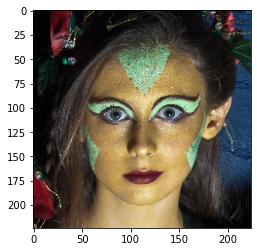

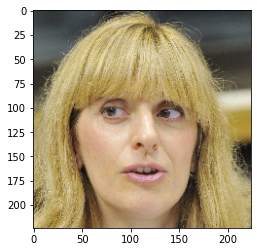

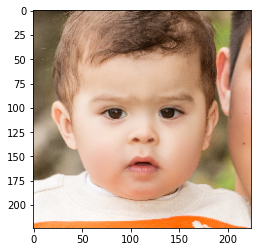

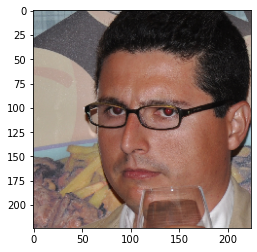

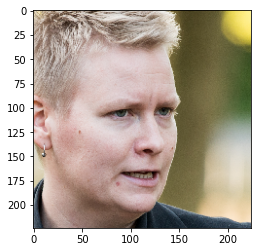

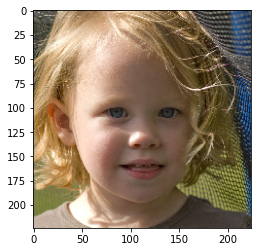

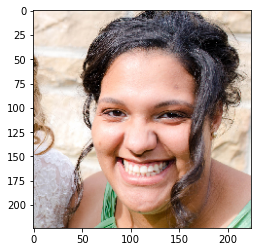

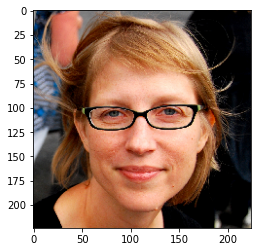

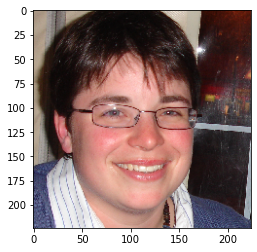

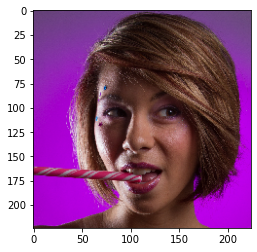

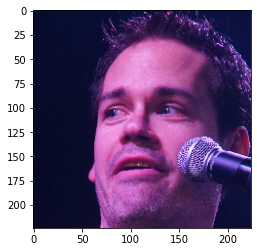

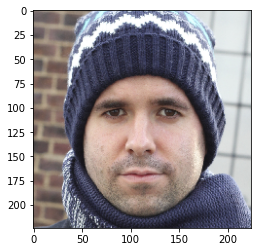

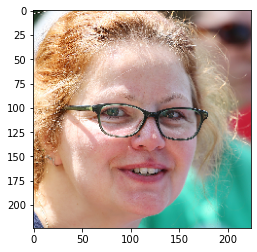

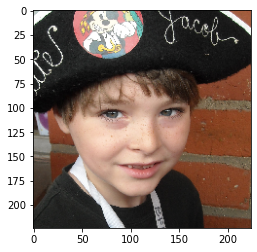

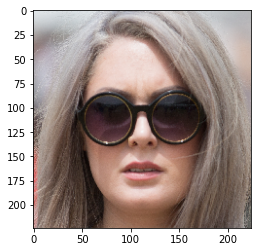

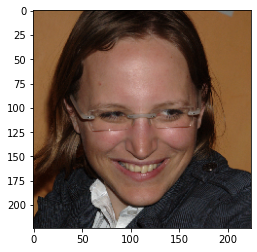

In [28]:
batch_of_images = train[5]
for i in batch_of_images : 
  plot_image(i)

### L Images


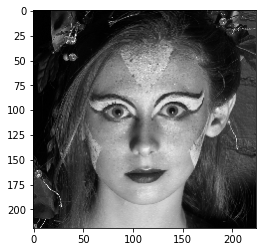

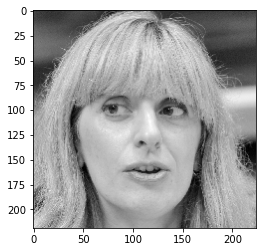

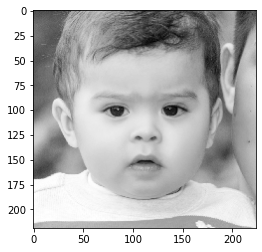

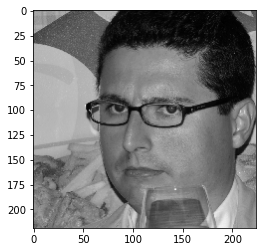

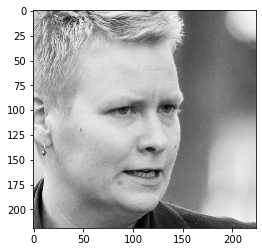

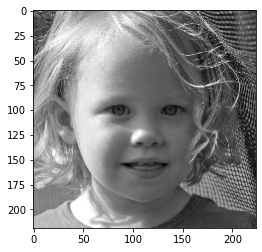

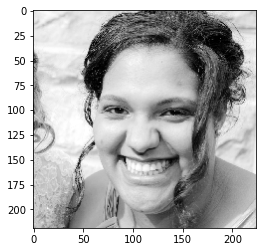

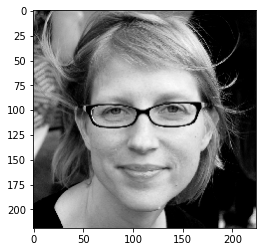

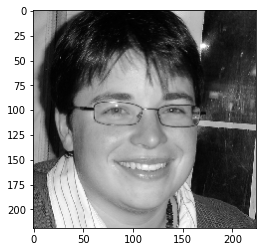

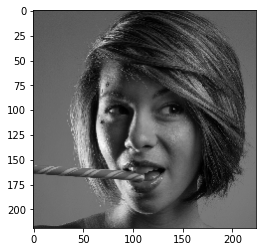

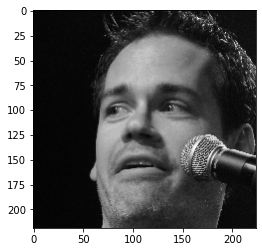

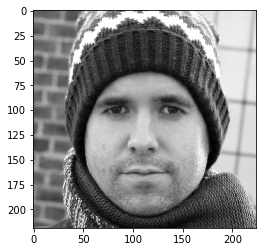

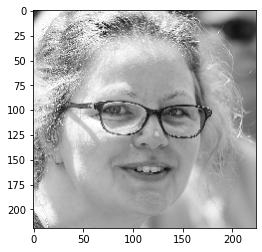

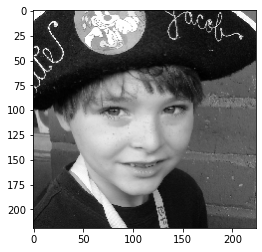

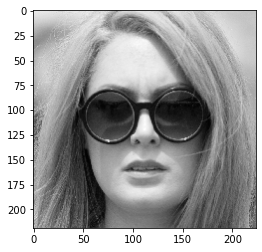

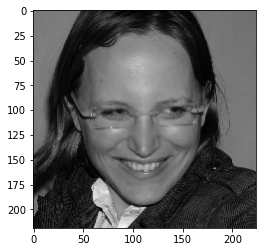

In [29]:
# plotting the L channel
for i in batch_of_images : 
  plot_image(convert_lab(i)[5:,:,0])

### a Images

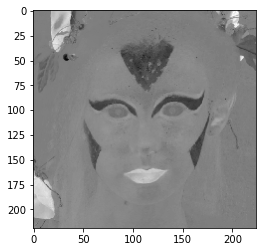

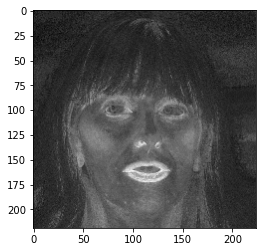

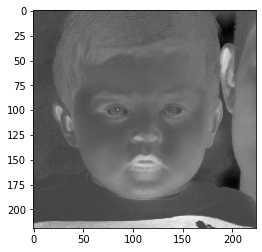

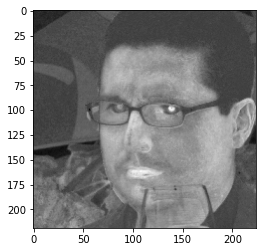

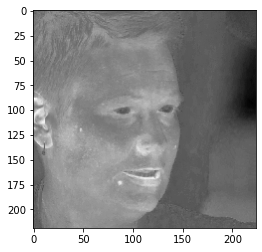

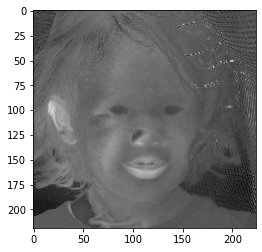

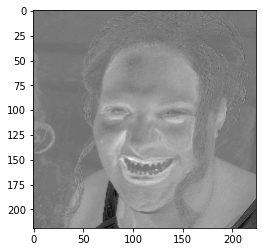

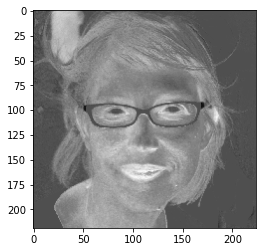

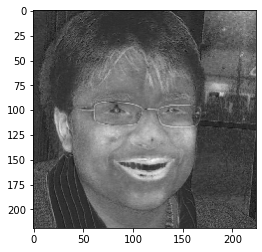

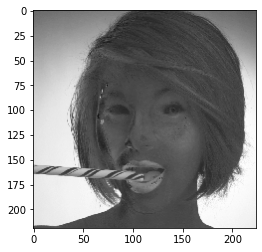

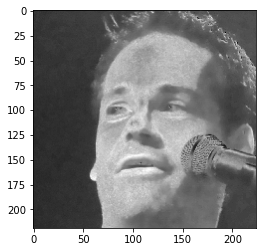

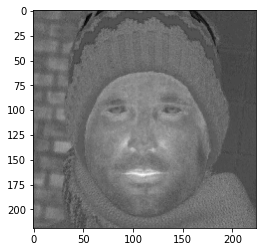

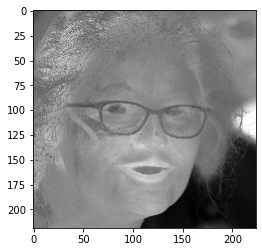

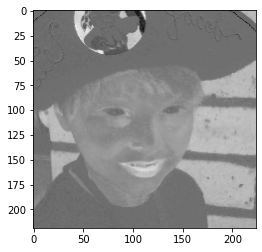

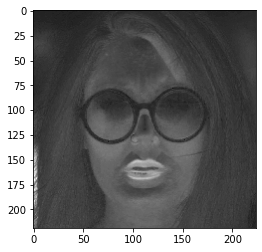

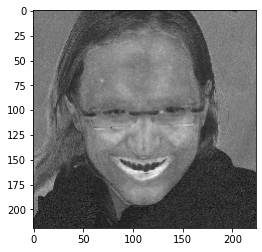

In [30]:
# plotting the a channel
for i in batch_of_images : 
  plot_image(convert_lab(i)[5:,:,1])

### b Images

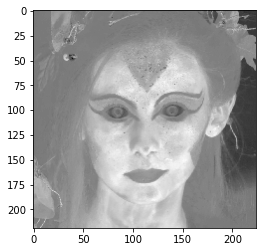

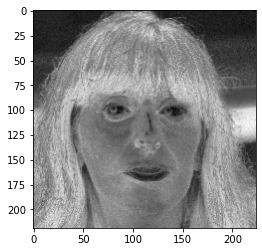

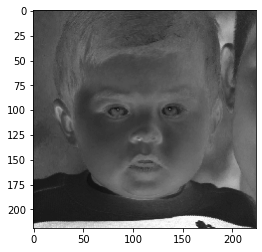

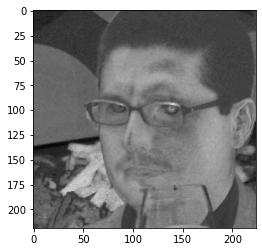

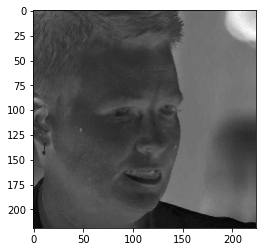

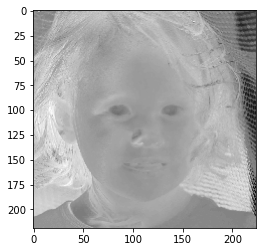

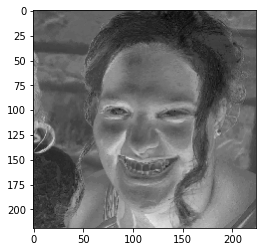

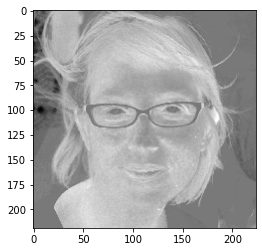

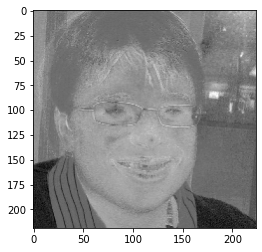

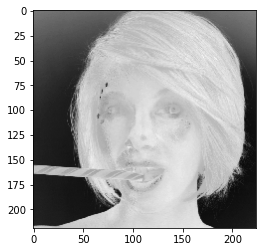

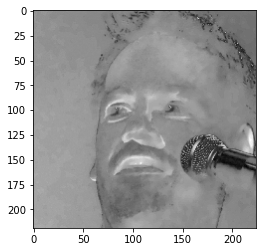

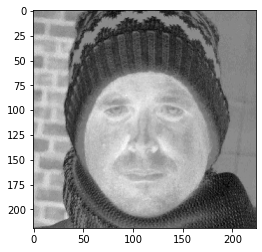

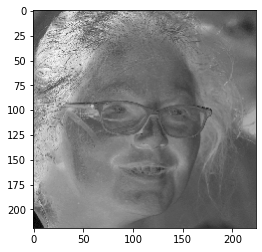

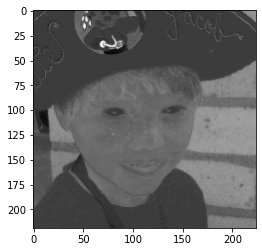

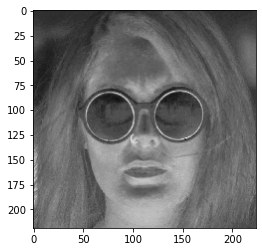

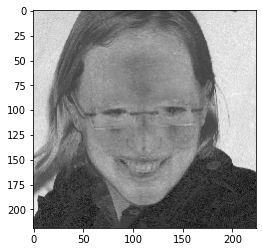

In [31]:
# plotting the b channel
for i in batch_of_images : 
  plot_image(convert_lab(i)[5:,:,2])

## Preparing the Numpy arrays

The numpy arrays for training and validation are constructed. All of the photographs in the training set are loaded one by one and converted to LAB format thereafter. The 'L' channel of our LAB image is in the x train list, whereas the 'A' and 'B' channels are in the y train list. The same may be said for x val and y val. Finally, the list is turned into a numpy array, which is the Tensorflow input type.

In [34]:
x_train = []
y_train = []
for i in tqdm(range(1000)) : 
  for image in train[i] : 
    try : 
      lab_image = convert_lab(image)
      x_train.append(lab_image[:,:,0])
      y_train.append(lab_image[:,:,1:] / 128)
    except : 
      print("Unexpected error. Maybe broken image.")
x_train = np.array(x_train)
y_train = np.array(y_train)
print(x_train.shape)
print(y_train.shape)           

C:\Users\Bekzod\AppData\Local\Temp/ipykernel_8236/247478064.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(1000)) :


  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
x_val = []       
y_val = []
for i in tqdm(range(187)) : 
  for image in val[i] : 
    try : 
      lab_image = convert_lab(image)
      x_val.append(lab_image[:,:,0])
      y_val.append(lab_image[:,:,1:] / 128)
    except : 
      print("Image might be broken")
x_val = np.array(x_val)
y_val = np.array(y_val)
print(x_val.shape)     
print(y_val.shape)

In [ ]:
x_train = x_train.reshape(x_train.shape[0], 224, 224, 1)
x_val = x_val.reshape(x_val.shape[0], 224, 224, 1)
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

In [ ]:
np.save("x_train", x_train)
np.save("y_train", y_train)
np.save("x_val", x_val)
np.save("y_val", y_val)          

In [ ]:
x_train = np.load("x_train.npy")  
y_train = np.load("y_train.npy")
x_val = np.load("x_val.npy")        
y_val = np.load("y_val.npy")


# Deep Learning Architecture - AutoEncoder 

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor= "loss", factor = 0.5, patience = 10,
                                                 min_lr = 0.000001, verbose = 1)
monitor_es = tf.keras.callbacks.EarlyStopping(monitor= "loss", patience = 25, restore_best_weights= False, verbose = True)

In [ ]:
# transfer learning
vgg_model = tf.keras.applications.vgg16.VGG16()
transfer_learned_encoder_model = tf.keras.models.Sequential()
for i, layer in enumerate(vgg_model.layers):
  if i < 19 : 
    transfer_learned_encoder_model.add(layer)
for layer in transfer_learned_encoder_model.layers:
  layer.trainable = False

transfer_learned_encoder_model.summary()

In [ ]:
vgg_features = []
for i, image in tqdm(enumerate(x_train)) : 
  image = cv2.merge((image, image, image))
  image = image.reshape((1,224, 224,3))
  prediction = transfer_learned_encoder_model.predict(image)
  prediction = prediction.reshape((7,7,512))
  vgg_features.append(prediction)
vgg_features = np.array(vgg_features)
print(vgg_features.shape)

In [ ]:
# Encoder
input_shape = (7, 7, 512)
i = tf.keras.layers.Input(shape = input_shape)  

#decoder
output = tf.keras.layers.Conv2D(filters = 128, kernel_size= (3,3), padding = "same", activation= "relu")(i)
output = tf.keras.layers.Conv2D(filters = 128, kernel_size= (3,3), padding = "same", activation= "relu")(i)
output = tf.keras.layers.Conv2D(filters = 128, kernel_size= (3,3), padding = "same", activation= "relu")(i)
output = tf.keras.layers.UpSampling2D((2, 2))(output)
output = tf.keras.layers.Conv2D(filters = 64, kernel_size= (3,3), padding = "same", activation= "relu")(output)
output = tf.keras.layers.Conv2D(filters = 64, kernel_size= (3,3), padding = "same", activation= "relu")(output)
output = tf.keras.layers.Conv2D(filters = 64, kernel_size= (3,3), padding = "same", activation= "relu")(output)
output = tf.keras.layers.UpSampling2D((2, 2))(output)
output = tf.keras.layers.Conv2D(filters = 32, kernel_size= (3,3), padding = "same", activation= "relu")(output)
output = tf.keras.layers.Conv2D(filters = 32, kernel_size= (3,3), padding = "same", activation= "relu")(output)
output = tf.keras.layers.Conv2D(filters = 32, kernel_size= (3,3), padding = "same", activation= "relu")(output)
output = tf.keras.layers.UpSampling2D((2, 2))(output)
output = tf.keras.layers.Conv2D(filters = 16, kernel_size= (3,3), padding = "same", activation= "relu")(output)
output = tf.keras.layers.Conv2D(filters = 16, kernel_size= (3,3), padding = "same", activation= "relu")(output)
output = tf.keras.layers.Conv2D(filters = 16, kernel_size= (3,3), padding = "same", activation= "relu")(output)
output = tf.keras.layers.UpSampling2D((2, 2))(output)
output = tf.keras.layers.Conv2D(filters = 2, kernel_size= (3,3), padding = "same", activation= "tanh")(output)
output = tf.keras.layers.UpSampling2D((2, 2))(output)

decoder_model = tf.keras.models.Model(inputs = i, outputs = output)
decoder_model.summary()

In [ ]:
decoder_model.compile(optimizer= tf.keras.optimizers.Adam(lr = 0.001), loss = "MSE", metrics = ["accuracy"])

In [ ]:
vgg_features.shape

In [ ]:
y_train.shape

In [ ]:
EPOCHS = 2500

In [93]:

with tf.device("/device:GPU:0"):
  history = decoder_model.fit(vgg_features, y_train, epochs = EPOCHS, verbose = 1, 
                      callbacks = [reduce_lr, monitor_es], batch_size = 16)                                               

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [ ]:
x = np.arange(0, EPOCHS, 1)                                                                  
plt.figure(1, figsize = (20, 12))                                  
plt.subplot(121)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(x, history.history["loss"], label = "Training Loss")
plt.plot(x, history.history["accuracy"], label = "Training Accuracy")
plt.grid(True)                           
plt.legend()   

In [26]:
!mkdir -p saved_model
transfer_learned_encoder_model.save('saved_model/encoder_model') 
decoder_model.save('saved_model/decoder_model')

A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file saved_model already exists.
Error occurred while processing: saved_model.


INFO:tensorflow:Assets written to: saved_model/encoder_model\assets
INFO:tensorflow:Assets written to: saved_model/decoder_model\assets


In [84]:
validation_images = x_val[:15]
vgg_features_val = []
for i, image in tqdm(enumerate(validation_images)) :
  image = cv2.merge((image, image, image))
  image = image.reshape((1,224,224,3))
  prediction = transfer_learned_encoder_model.predict(image)
  prediction = prediction.reshape((7,7,512))
  vgg_features_val.append(prediction)
vgg_features_val = np.array(vgg_features_val)
print(vgg_features_val.shape)

C:\Users\Bekzod\AppData\Local\Temp/ipykernel_12852/3185325020.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, image in tqdm(enumerate(validation_images)) :


0it [00:00, ?it/s]

(15, 7, 7, 512)


In [85]:
ab_pred = decoder_model.predict(vgg_features_val)
ab_pred = ab_pred * 128
print(ab_pred.shape)

(15, 224, 224, 2)


In [86]:
print(validation_images.shape)

(15, 224, 224, 1)


C:\Users\Bekzod\anaconda3\lib\site-packages\skimage\color\colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 5167 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


TypeError: Invalid shape (15, 224, 224, 1) for image data

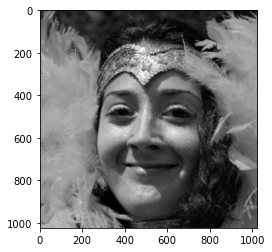

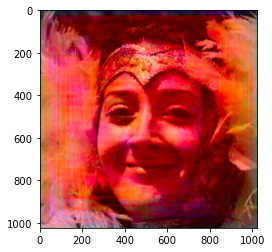

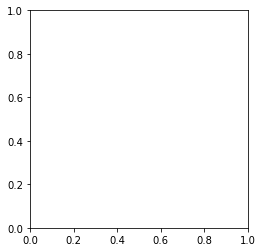

In [87]:
for i in range(validation_images.shape[0]) : 
  image = validation_images[i]
  image = image.reshape((224 ,224))
  
  reconstructed_image =  np.zeros((224, 224, 3))
  reconstructed_image[:,:,0] =  image
  reconstructed_image[:,:,1:] = ab_pred[i]

  #reconstructed_image = reconstructed_image.astype(np.uint8)
  reconstructed_image = convert_rgb(reconstructed_image)
  
  image = cv2.resize(image, (1024, 1024))
  reconstructed_image = cv2.resize(reconstructed_image, (1024, 1024))

  plot_image(image)
  plot_image(reconstructed_image) 
  plot_image(validation_images)